Given two measures $f^+$ and $f^-$ with equal mass, the [Monge-Kantorovich Equations](https://www.intlpress.com/site/pub/files/_fulltext/journals/cdm/1997/1997/0001/CDM-1997-1997-0001-a002.pdf) reads as finding the Kantorovich Potential $u^*$ and
the Optimal Transport Densisity $\mu^*$ solving the following system of PDE
$$
\nabla \cdot ( \mu^*(x) \nabla u^*(x) )= f^{+}(x)-f^{-}(x) \\
|\nabla u^*(x)|\leq 1 \\
|\nabla u^*(x)|=1 \mbox{\ where \ } \mu^*(x)>0. \\
$$
This is the PDE-based formulation of the Optimal Transport Problem with cost equal to the Euclidean distance.

In this notebook we reproduce Test-Case-1
[FaccaDaneriCardinPutti2020](https://link.springer.com/article/10.1007/s10915-020-01170-8).
where the problem is settled in the square $[0,1]\times[0,1]\subset R^2$ with $f^+$ and $f^-$
given by
$$
f^+(x)=2 \ \mbox{on}\  [1/8,3/8]\times [1/4,3/4] \\
f^-(x)=2 \ \mbox{on}\  [5/8,7/8]\times [1/4,3/4] \\
$$
and zero elsewhere.

We show how to pass the input data (triangulationed grid, forcings terms) and the algorithm controls to the dmk solver. Copy this notebook, change the triangulation and the measures $f^+$ and $f^-$ to run your own experiments.

In [1]:
# 
# Loading stardard and dmk pyhton modules
#

# Standard tools
import sys
import numpy as np
import os
current_source_dir=os.getcwd()

# Import I/O for timedata
try:
    sys.path.append('../../../../../globals/python/timedata/')
    import timedata as td
except:
    print("Global repo non found")

# Import geometry tools
sys.path.append('../../../../../geometry/python/')
import meshtools as mt
sys.path.append('../../../preprocess/assembly/')
import example_grid

# Import dmk tools
sys.path.append('../../')
import dmk_p1p0 


relative_libpath='../../../../build/python/fortran_python_interface/'
dmk_lib_path=os.path.abspath(os.path.normpath(current_source_dir+'/'+relative_libpath))
sys.path.append(dmk_lib_path)
from dmk import (Dmkcontrols,  # controls for dmk simulations)
                 Timefunctionals # information of time/algorithm evolution
                )
# Import plot tools
import matplotlib.pyplot as plt

/home/fh/srcs/globals/python/timedata
/home/fh/srcs/dmk_solver/otp_solver/python/examples/Ambrosio
/home/fh/srcs/dmk_solver/otp_solver/preprocess/assembly
/home/fh/srcs/globals/python/timedata
/home/fh/srcs/dmk_solver/build/python/fortran_python_interface


111.33 4393.33 1247.33 1585.33


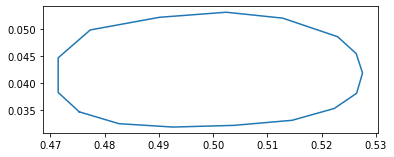

regions 4
Region 0 [0.5012659096216722, 0.04150221858944421, 1.0, 3.814697265625e-07] 3.814697265625e-07
Region 1 [0.26044517748715557, 0.04090193445430486, 2.0, 3.814697265625e-07] 3.814697265625e-07
Region 2 [0.761703448544294, 0.04397030203954541, 3.0, 3.814697265625e-07] 3.814697265625e-07
len_attributes 231254
cells= 231254 node= 116169


In [2]:
#
# Define mesh for spatial disctetization.
# Build the "coord" and "topol" numpy arrays describing coordinate and topology of the mesh.
#

# set mesh size 
ndiv=512
length=1.0/float(ndiv)
nref=0

def read_coord(file):
    # Using readlines()
    file1 = open(file, 'r')
    lines = file1.readlines()
    file1.close()
    coord=[]
    # Strips the newline character
    for i,line in enumerate(lines):
        #coord.append(float(line.strip(",")))
        x, y = line.strip().split(",")
        #print(x, ' my ',y)
        coord.append([float(x),float(y)])
        #print(coord[i])
    return np.array(coord);


source_coord=read_coord('source_coord.txt')
sink_left_coord=read_coord('sink_left_coord.txt')
sink_right_coord=read_coord('sink_right_coord.txt')


xmin=min(np.min(sink_left_coord[:,0]),
         np.min(sink_right_coord[:,0]),
         np.min(source_coord[:,0]))  
ymin=min(np.min(sink_left_coord[:,1]),
         np.min(sink_right_coord[:,1]),
         np.min(source_coord[:,1]))

xmax=max(np.max(sink_left_coord[:,0]),
         np.max(sink_right_coord[:,0]),
         np.max(source_coord[:,0]))  
ymax=max(np.max(sink_left_coord[:,1]),
         np.max(sink_right_coord[:,1]),
         np.max(source_coord[:,1]))  

print(xmin,xmax,ymin,ymax)

def scale(coord,xmin,xmax,ymin,ymax):
    coord[:,0]=(coord[:,0]-xmin)/(xmax-xmin)
    coord[:,1]=(coord[:,1]-ymin)/(xmax-xmin)
    return coord;
xl=1
yl=(ymax-ymin)/(xmax-xmin)

source_coord=scale(source_coord,xmin,xmax,ymin,ymax)
sink_left_coord=scale(sink_left_coord,xmin,xmax,ymin,ymax)
sink_right_coord=scale(sink_right_coord,xmin,xmax,ymin,ymax)

coord=list(source_coord)

import matplotlib.pyplot as plt

coord.append(coord[0]) #repeat the first point to create a 'closed loop'

xs, ys = zip(*coord) #create lists of x and y values

plt.figure()
plt.plot(xs,ys) 
plt.axis('scaled')
plt.show() # if you need...

# build grid using prebuild examples 
areas=np.zeros(3)
areas[:]=0.1*length**2

points, vertices, coord,topol,element_attributes = example_grid.example_grid(
    #'rect_cnst',length)

    'polygons',length,[[source_coord,sink_left_coord,sink_right_coord],0.01,areas])



print ('cells=',len(topol),'node=',len(coord))


In [3]:
mt.write_grid(coord,topol,'grid.dat')


In [4]:
#
# We create piecewise constant rapresentations of $f,f^+,f-$ and $\mu^*$,
# evaluating the function on cell centroids.
#

# define source and sink functions, value of grid centroids
ncell=len(topol)
bar_cell=mt.make_bar(coord,topol).transpose()
size_cell=mt.make_size(coord,topol);
source_cell=np.zeros([ncell]); sink_cell=np.zeros([ncell]); opttdens_cell=np.zeros([ncell])
tdens0=np.ones([ncell])
tdens0[:]=0.01
for i in range(ncell):
    if (element_attributes[i]==1):
        source_cell[i] = 1
    elif (element_attributes[i]==2 or element_attributes[i]==3):
        sink_cell[i]   = 1
        tdens0[i]=2
    if (abs(bar_cell[1,i]-0.04)<0.005):
        tdens0[i]=10
forcing_cell=source_cell-sink_cell*(np.dot(size_cell,source_cell)/np.dot(size_cell,sink_cell))

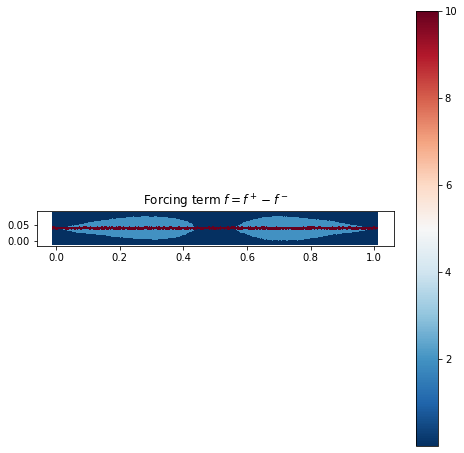

In [5]:
import matplotlib.tri as mtri
#
# plot forcing term
#
triang = mtri.Triangulation(coord.transpose()[0,:], coord.transpose()[1,:], topol)
fig1, ax1 = plt.subplots(figsize=(8, 8)); ax1.set_aspect('equal')
tpc = ax1.tripcolor(triang, tdens0 , cmap='RdBu_r')
fig1.colorbar(tpc)
ax1.set_title('Forcing term $f=f^+-f^-$')
plt.show()



We load the controls from file. You can either change it in the file or change some controls in the next cell.

In [6]:
# init from file from file
ctrl = dmk_p1p0.init_dmkctrl(tdens_gfvar='tdens',explicit_implicit='explicit')

# The user can change any controls inside the ctrl type.
# Here we set the saving frequency (save all) and the convergence tolerance
ctrl.id_save_dat=3
ctrl.fn_tdens='tdens.dat'
ctrl.fn_pot='pot.dat'
ctrl.fn_statistics='dmk.log'


#ctrl.max_time_iterations=3
ctrl.tolerance_system_variation=1e-4

# tune linear system to speed up convergence
ctrl.outer_solver_approach='AGMG' # also AGMG if available
ctrl.outer_krylov_scheme='PCG'

# uncomment and try also this setting
ctrl.outer_solver_approach='AGMG' 
ctrl.outer_krylov_scheme='PCG'
ctrl.relax_direct=1e-12
ctrl.relax4prec=1e-8

ctrl.max_time_iterations=3000
ctrl.deltat=0.4

ctrl.deltat_control=1

In [7]:
[info,opttdens,optpot,topol_subgrid,coord_subgrid,timefun] = dmk_p1p0.solve_MinFluxProblem(topol,coord,forcing_cell,
                                                                                           forcing_nodes=None,
                                                                                           pflux=1.05,
                                                                                        tolerance=1e-4,
                                                                                           ctrl=ctrl,tdens0=tdens0)
if (info==0): print('Convergence achieved')

ctrl.id_subgrid 1
231254 116169 3
Convergence achieved


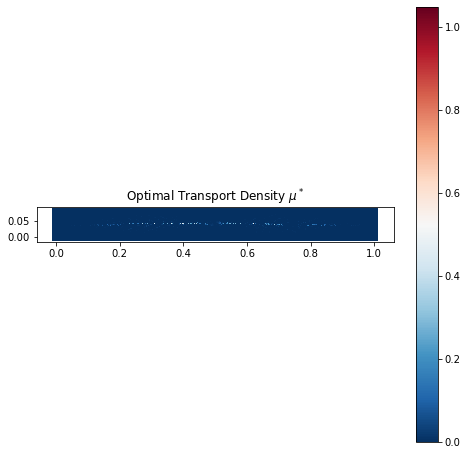

In [8]:
import matplotlib.tri as mtri
# plot forcing term
triang = mtri.Triangulation(coord.transpose()[0,:], coord.transpose()[1,:], topol)
fig1, ax1 = plt.subplots(figsize=(8, 8)); ax1.set_aspect('equal')
tpc = ax1.tripcolor(triang, opttdens , cmap='RdBu_r')
fig1.colorbar(tpc)
ax1.set_title('Optimal Transport Density $\mu^*$')
plt.show()

2117


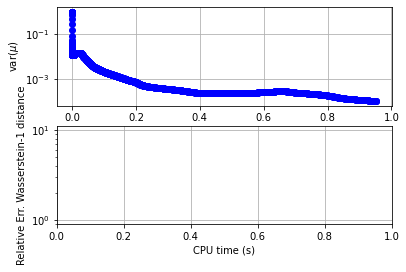

In [9]:
# plot convergence toward steady state
print(timefun.last_time_iteration)
time      = np.array(timefun.time[0:timefun.last_time_iteration]);
cpu_time  = np.array(timefun.cpu_time[0:timefun.last_time_iteration])
var_tdens = np.array(timefun.var_tdens[1:timefun.last_time_iteration])
wass1     = np.array(timefun.lyapunov[1:timefun.last_time_iteration])
#errwass1=(wass1[:]-exact_wass1)/(exact_wass1)

plt.figure(1)
plt.subplot(211)
plt.yscale('log')
plt.ylabel('var($\mu$)')
plt.xlabel('CPU time (s)')
plt.grid(True)
plt.plot(cpu_time[1:], var_tdens, 'bo--')

plt.subplot(212)
plt.yscale('log')
plt.ylabel('Relative Err. Wasserstein-1 distance')
plt.xlabel('CPU time (s)')
plt.grid(True)
#plt.plot(cpu_time[1:], errwass1, 'ro--')
plt.show()

In [10]:
"""import pyvtk

vtk = pyvtk.VtkData(\
  pyvtk.UnstructuredGrid(points=coord,
    triangle=topol
    ),
  pyvtk.CellData(pyvtk.Scalars(opttdens,name='OptTdens')),
  'artieries'
  )
vtk.tofile('OptTdens.vtk')
"""

"import pyvtk\n\nvtk = pyvtk.VtkData(  pyvtk.UnstructuredGrid(points=coord,\n    triangle=topol\n    ),\n  pyvtk.CellData(pyvtk.Scalars(opttdens,name='OptTdens')),\n  'artieries'\n  )\nvtk.tofile('OptTdens.vtk')\n"

In [11]:
td.write_steady_timedata('opttdens.dat',opttdens)


In [12]:
td.write_steady_timedata('forcing.dat',forcing_cell)